## Using Machine Learning to Predict House Prices in Washington State
by Hanna Seyoum

### III. Data Story

In [55]:
# import necessary modules/libraries

import numpy as  np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr

from matplotlib import rcParams
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=0.7)
sns.set_palette("Greens_r")
#set_palette("Set1", 8, .75) # makes plot lines red

from ipywidgets import interact, widgets

from sklearn.preprocessing import Imputer # to impute missing data

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [4]:
# Load the Washington housing dataset
df1 = pd.read_csv('house_price_prediction.csv')
print("The Washington housing dataset has {} data points with {} variables each.".format(*df1.shape))
df1.head(2)

The Washington housing dataset has 4600 data points with 18 variables each.


,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.5,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2384000.0,5.0,2.5,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA


## EDA and Summary Statistics

In [5]:
# inspecting structure of dataframe & number of null values (if any)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 18 columns):
date             4600 non-null object
price            4600 non-null float64
bedrooms         4600 non-null float64
bathrooms        4600 non-null float64
sqft_living      4600 non-null int64
sqft_lot         4600 non-null int64
floors           4600 non-null float64
waterfront       4600 non-null int64
view             4600 non-null int64
condition        4600 non-null int64
sqft_above       4600 non-null int64
sqft_basement    4600 non-null int64
yr_built         4600 non-null int64
yr_renovated     4600 non-null int64
street           4600 non-null object
city             4600 non-null object
statezip         4600 non-null object
country          4600 non-null object
dtypes: float64(4), int64(9), object(5)
memory usage: 647.0+ KB


In [6]:
df1.describe()

#notice: price, bedrooms, & bathrooms have min of 0. Needs furthern investigation

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated
count,4.600000e+03,4600.000000,4600.000000,4600.000000,4.600000e+03,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000
mean,5.519630e+05,3.400870,2.160815,2139.346957,1.485252e+04,1.512065,0.007174,0.240652,3.451739,1827.265435,312.081522,1970.786304,808.608261
std,5.638347e+05,0.908848,0.783781,963.206916,3.588444e+04,0.538288,0.084404,0.778405,0.677230,862.168977,464.137228,29.731848,979.414536
min,0.000000e+00,0.000000,0.000000,370.000000,6.380000e+02,1.000000,0.000000,0.000000,1.000000,370.000000,0.000000,1900.000000,0.000000
25%,3.228750e+05,3.000000,1.750000,1460.000000,5.000750e+03,1.000000,0.000000,0.000000,3.000000,1190.000000,0.000000,1951.000000,0.000000
50%,4.609435e+05,3.000000,2.250000,1980.000000,7.683000e+03,1.500000,0.000000,0.000000,3.000000,1590.000000,0.000000,1976.000000,0.000000
75%,6.549625e+05,4.000000,2.500000,2620.000000,1.100125e+04,2.000000,0.000000,0.000000,4.000000,2300.000000,610.000000,1997.000000,1999.000000
max,2.659000e+07,9.000000,8.000000,13540.000000,1.074218e+06,3.500000,1.000000,4.000000,5.000000,9410.000000,4820.000000,2014.000000,2014.000000


Notice `price`, `bedrooms`, & `bathroom` have a minimum value of 0. Needs further investigation.

In [7]:
df2 = df1.copy()

# change date col to datetime
df2['date'] = pd.to_datetime(df2['date'])

# change data types of 'waterfront' & 'condition' to categorical
df2[['waterfront', 'condition']] = df1[['waterfront', 'condition']].astype('category')

#df2['waterfront'] = df2.waterfront.astype(int)

# remove country column since all houses are in the US, & city, state, zipcode are listed
df2 = df2.drop('country', axis='columns')

# split statezip into state & zipcode columns & remove statezip col
df2['state'] = df2['statezip'].apply(lambda x: x.split(' ')[0])
df2['zipcode'] = df2['statezip'].apply(lambda x: int(x.split(' ')[1]))
df2 = df2.drop('statezip', axis='columns')

# add total_sqft column: sqft_above + sqft_lot
df2['total_sqft'] = df2.sqft_living + df2.sqft_lot

## Some statistics

In [8]:
# Minimum price of the data
minimum_price = round(np.amin(df2["price"]), 2)

# Maximum price of the data
maximum_price = round(np.amax(df2["price"]), 2)

# Mean price of the data
mean_price = round(np.mean(df2["price"]), 2)

# Median price of the data
median_price = round(np.median(df2["price"]), 2)

# Standard deviation of prices of the data
std_price = round(np.std(df2["price"]), 2)

# Show the calculated statistics
print("Statistics for Washington housing dataset:\n")
print("Minimum price: ${}".format(minimum_price)) 
print("Maximum price: ${}".format(maximum_price))
print("Mean price: ${}".format(mean_price))
print("Median price ${}".format(median_price))
print("Standard deviation of prices: ${}".format(std_price))

Statistics for Washington housing dataset:

Minimum price: $0.0
Maximum price: $26590000.0
Mean price: $551962.99
Median price $460943.46
Standard deviation of prices: $563773.41


## Feature Observation

Confirm sqft_living is sqft_above + sqft_basement?

In [9]:
# Notice sqft_above & sqft_basement add up to sqft_living.
(df2.sqft_living == df2.sqft_above + df2.sqft_basement).all()

True

## Missing/zero values & outliers

### Zero Values

In [75]:
df3 = df2.copy()

# counting the number of zero values in each column
df3.isin([0]).sum()

date                0
price              49
bedrooms            2
bathrooms           2
sqft_living         0
sqft_lot            0
floors              0
waterfront       4567
view             4140
condition           0
sqft_above          0
sqft_basement    2745
yr_built            0
yr_renovated     2735
street              0
city                0
state               0
zipcode             0
total_sqft          0
dtype: int64

Notice: `waterfront` & `view` have categorical values of 0 & 1.  
Nearly half of `yr_renovated` are 0.  
Inspect the 0s in `bedrooms` & `bathrooms`

In [11]:
# 0 Price

price_zero_len = round((len(df3[df3.price == 0])/len(df3)) * 100, 1)
print('There are {} houses worth $0, which are {}% of entire data. Therefore created a column of boolean arrays with 1s for when price is $0 & 0s for when price is not $0.'.format(len(df3[df3.price == 0]), price_zero_len))
print('')

df3['price_is_zero'] = (df3['price'] == 0).astype(int)

There are 49 houses worth $0, which are 1.1% of entire data. Therefore created a column of boolean arrays with 1s for when price is $0 & 0s for when price is not $0.



In [12]:
# 0 yr_renovated

# percentage of 'yr_renovated' col with 0 entries
yr_renov_0 = round((len(df3[df3['yr_renovated'] == 0]) / len(df3)) * 100, 1)
print("{}% of yr_renovated column has 0 values, therefore added a column of boolean arrays with 1s for when yr_renov is 0 & 0s for others.".format(yr_renov_0))

df3['renov_date_is_zero'] = (df3['yr_renovated'] == 0).astype(int)

59.5% of yr_renovated column has 0 values, therefore added a column of boolean arrays with 1s for when yr_renov is 0 & 0s for others.


In [13]:
# 0 bedrooms & bathrooms

df3[df3.bedrooms == 0]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_basement,yr_built,yr_renovated,street,city,state,zipcode,total_sqft,price_is_zero,renov_date_is_zero
2365,2014-06-12,1095000.0,0.0,0.0,3064,4764,3.5,0,2,3,...,0,1990,2009,814 E Howe St,Seattle,WA,98102,7828,0,0
3209,2014-06-24,1295648.0,0.0,0.0,4810,28008,2.0,0,0,3,...,0,1990,2009,20418 NE 64th Pl,Redmond,WA,98053,32818,0,0


There are 2 houses with 0s as their bedrooms & bathrooms shown above.  
We can see that the houses are both worth over 1 mil, therefore the 0s must be errors.  
Will replace 0s with the mean bedroom & bathroom values of 3 & 2 respectively.

In [14]:
df3["bedrooms"].replace({0: round(df3["bedrooms"].mean(), 0)}, inplace=True)
df3["bathrooms"].replace({0: round(df3["bathrooms"].mean(), 0)}, inplace=True)

### Outliers

Text(0.5, 1.0, 'Relationship between Bedrooms and Price')

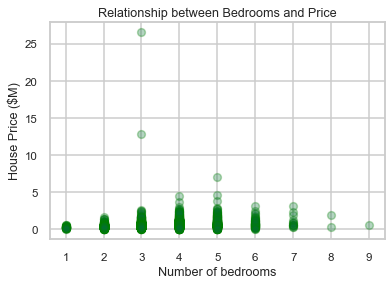

In [15]:
# Price

plt.scatter(df3["bedrooms"], df3["price"].div(1000000), alpha = 0.3 ,s=60 , edgecolors='g')
plt.xlabel("Number of bedrooms")
plt.ylabel("House Price ($M)")
plt.title("Relationship between Bedrooms and Price")
#plt.grid('on')
#ax.set_facecolor('grey')

Notice 2 outliers priced around \\$13 M & \\$26 M, both with 3 bedrooms.

In [16]:
'''
# normalized / scaled scatter plot of bedrooms vs price
X = df3["price"].values.reshape(-1,1)
X = MinMaxScaler().fit_transform(X)
plt.scatter(df3["bedrooms"], X, s=60, alpha=0.3, edgecolors='g')
plt.xlabel("Number of bedrooms")
plt.ylabel("Scaled House Price")
plt.title("Relationship between Bedrooms and Price")
#plt.grid('on')
'''

'\n# normalized / scaled scatter plot of bedrooms vs price\nX = df3["price"].values.reshape(-1,1)\nX = MinMaxScaler().fit_transform(X)\nplt.scatter(df3["bedrooms"], X, s=60, alpha=0.3, edgecolors=\'g\')\nplt.xlabel("Number of bedrooms")\nplt.ylabel("Scaled House Price")\nplt.title("Relationship between Bedrooms and Price")\n#plt.grid(\'on\')\n'

Text(0.5, 1.0, 'Relationship between Bedrooms and Price (Without Outliers)')

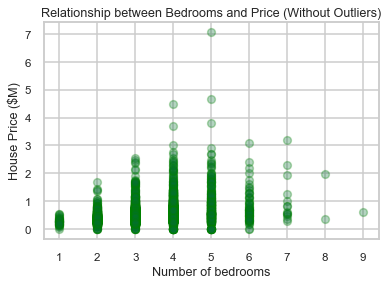

In [17]:
# removing price outliers
df_no_outs = df3[df3.price < 10000000].copy()

# plot with removed price outliers
plt.scatter(df_no_outs["bedrooms"], df_no_outs["price"].div(1000000), alpha = 0.3 ,s=60 , edgecolors='g')
plt.xlabel("Number of bedrooms")
plt.ylabel("House Price ($M)")
plt.title("Relationship between Bedrooms and Price (Without Outliers)")

A polynomial (quadratic) regression might fit the data better.  
(squared 'bedrooms' when modelling)

In [18]:
df3[df3.price > 10000000]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_basement,yr_built,yr_renovated,street,city,state,zipcode,total_sqft,price_is_zero,renov_date_is_zero
4346,2014-06-23,12899000.0,3.0,2.5,2190,11394,1.0,0,0,3,...,640,1956,2001,5426 40th Ave W,Seattle,WA,98199,13584,0,0
4350,2014-07-03,26590000.0,3.0,2.0,1180,7793,1.0,0,0,4,...,0,1992,0,12005 SE 219th Ct,Kent,WA,98031,8973,0,1


House price of greater than $10 milion might be too high for a 3 bedroom house. Do they have higher square footage than the other houses?

Text(0.5, 1.0, 'House Size vs Price')

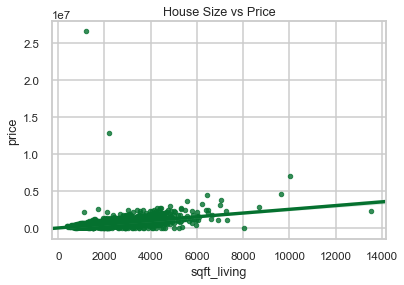

In [43]:
sns.regplot(data=df3, x='sqft_living', y='price', fit_reg=True, scatter_kws={'s':20})
plt.title("House Size vs Price")

We see in the above plot that the size of the houses priced over $10 mil does not explain why they're priced very high. Might be an error.

# Data Visualization

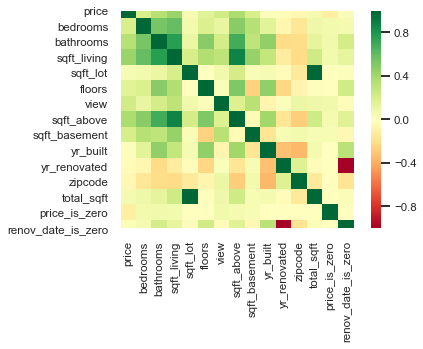

In [21]:
sns.heatmap(df3.corr(), square=True, cmap='RdYlGn')

Text(0.5, 1.0, 'Barplot of Waterfront vs Price')

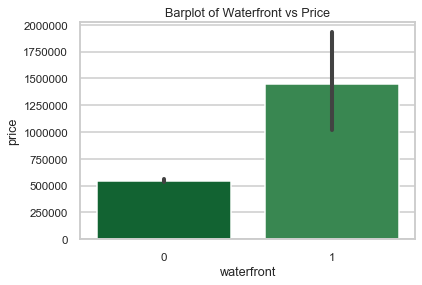

In [74]:
sns.barplot(x=df3.waterfront, y=df3.price)
plt.title("Barplot of Waterfront vs Price")

The above plot confirms that houses with waterfronts are priced higher than houses without.

Text(0.5, 1.0, 'House Condition vs Price')

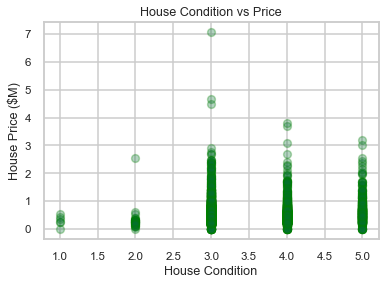

In [23]:
plt.scatter(df_no_outs["condition"], df_no_outs["price"].div(1000000), alpha = 0.3 ,s=60 , edgecolors='g')
plt.xlabel("House Condition")
plt.ylabel("House Price ($M)")
#plt.ylim((0, 5))
plt.title("House Condition vs Price")

As expected, the above plot shows that houses in poor condition are priced much lower than houses in better condition. It also shows that majority of the houses are in moderate condition (level 3). Follows a slightly parabolic shape.

Text(0.5, 1.0, 'House size vs Price')

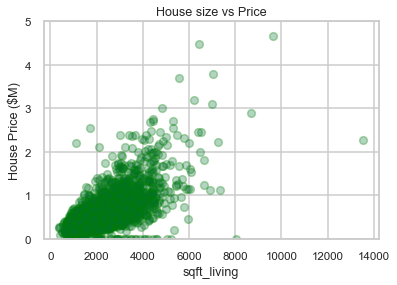

In [24]:
plt.scatter(df3["sqft_living"], df3["price"].div(1000000), alpha = 0.3 ,s=60 , edgecolors='g')
plt.xlabel("sqft_living")
plt.ylabel("House Price ($M)")
plt.ylim((0, 5))
plt.title("House size vs Price")

We can see clearly that houses with higher square footages are worth more.

Text(0.5, 1.0, 'Lineplot of Year Built vs Price')

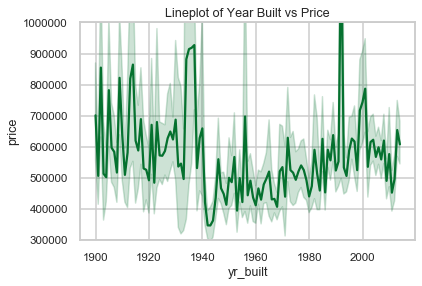

In [25]:
sns.lineplot(df3.yr_built, df3.price)
plt.ylim(300000,1000000)
plt.title("Lineplot of Year Built vs Price")

In the above plot we can see that house prices are higher with houses that are very old and also new. Old houses could be priced higher due to their historical value.

### Scatterplot matrix & heatmap to visualize the pairwise relationships & correlations between features

'sns.pairplot(df4, height=2.5)\nplt.tight_layout()\n'

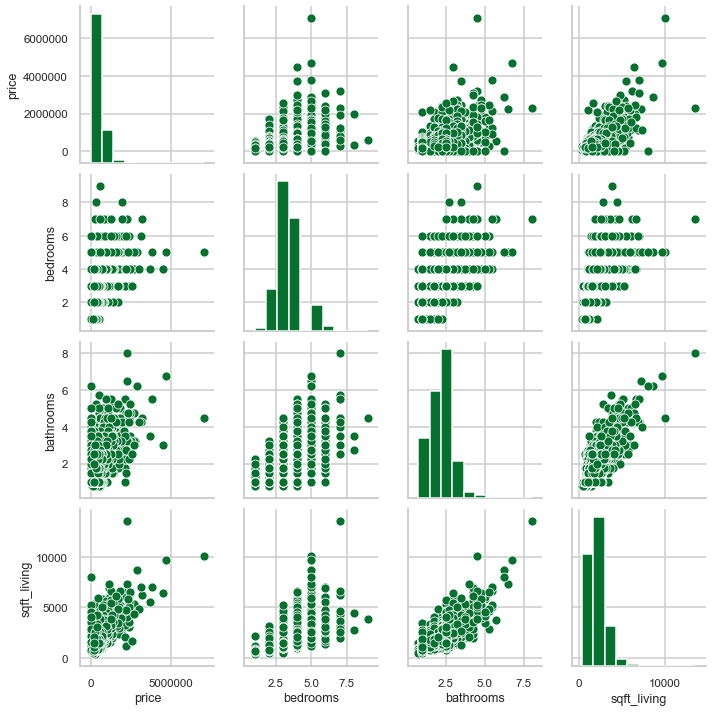

In [27]:
features = df_no_outs[['price', 'bedrooms', 'bathrooms', 'sqft_living']]

sns.pairplot(features, height=2.5)
plt.tight_layout()
'''sns.pairplot(df4, height=2.5)
plt.tight_layout()
'''

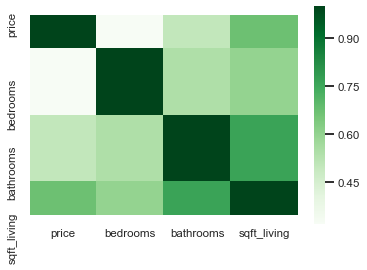

In [28]:
sns.heatmap(features.corr(), square=True, cmap='Greens')

## Statistical Data Analysis

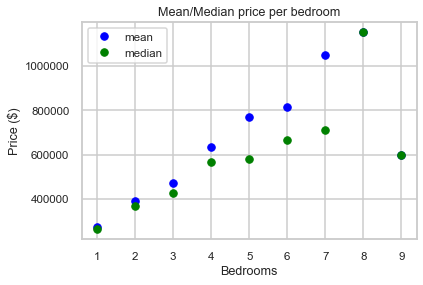

In [77]:
meanprice_bedrooms = df_no_outs.groupby('bedrooms')['price'].mean()
medianprice_bedrooms = df_no_outs.groupby('bedrooms')['price'].median()

plt.plot(meanprice_bedrooms, marker='.', linestyle='none', markersize='15', c='b', label='mean')
plt.plot(medianprice_bedrooms, marker='.', linestyle='none', markersize='15', c='g', label='median')
plt.title("Mean/Median price per bedroom")
plt.xlabel("Bedrooms")
plt.ylabel("Price ($)")
plt.legend()

Notice the price drop at 9 bedrooms. This could be due to limited 9 bedroom data. Beides that, `bedrooms` & `price` have a linear relationship.

Notice also that mean price is slightly larger than median price. This could be due to outliers affecting the mean.

In [65]:
corr, _  = pearsonr(df_no_outs['bedrooms'], df_no_outs['price'])
corr

0.318309808508883

The correlation between `bedrooms` and `price` seems quite low, but correlation between `bedrooms` & mean `price` would probably be higher.

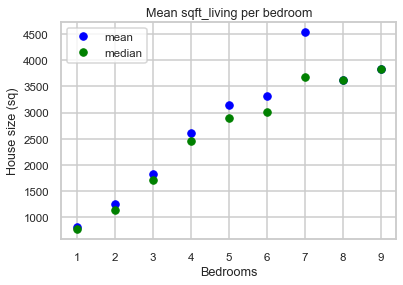

In [78]:
meansqft_bedroom = df_no_outs.groupby("bedrooms")["sqft_living"].mean()
mediansqft_bedroom = df_no_outs.groupby("bedrooms")["sqft_living"].median()

plt.plot(meansqft_bedroom, marker='.', linestyle='none', markersize='15', label='mean', c='b')
plt.plot(mediansqft_bedroom, marker='.', linestyle='none', markersize='15', label='median', c='g')
plt.title("Mean sqft_living per bedroom")
plt.xlabel("Bedrooms")
plt.ylabel("House size (sq)")
plt.legend()

Here, `bedrooms` and mean `sqft_living` have a strong positive linear relationship. The mean and median prices are very similar.

In [83]:
corr, _  = pearsonr(df_no_outs['bedrooms'], df_no_outs['sqft_living'])
corr

0.5993653746492815

In [104]:
corr, _  = pearsonr(df_no_outs['bathrooms'], df_no_outs['yr_built'])
corr

0.4651085818981163

`bathrooms` & `yr_built` have a moderate positive correlation. This means newer houses are built with more bathrooms.

### ecdf plots of house price by month (to see if there's any shift)

In [91]:
df4 = df_no_outs.copy()
df4['month'] = pd.DatetimeIndex(df4['date']).month

In [92]:
df4.month.unique()

array([5, 6, 7])

In [95]:
may_price = df4[df4.month==5]['price']
june_price = df4[df4.month==6]['price']
july_price = df4[df4.month==7]['price']

In [88]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    n = len(data)

    x = np.sort(data)

    y = np.arange(1, n+1) / n

    return x, y

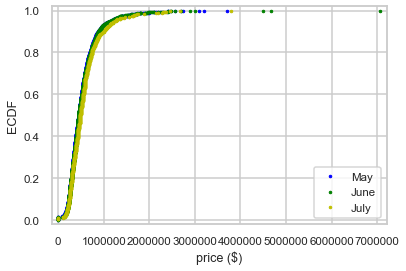

In [99]:
# Compute ECDFs
x_5, y_5 = ecdf(may_price)
x_6, y_6 = ecdf(june_price)
x_7, y_7 = ecdf(july_price)

# Plot the ECDFs
_ = plt.plot(x_5, y_5, marker='.', linestyle='none', markersize=5, c='b')
_ = plt.plot(x_6, y_6, marker='.', linestyle='none', markersize=5, c='g')
_ = plt.plot(x_7, y_7, marker='.', linestyle='none', markersize=5, c='y')

# Set margins
plt.margins(0.02)

# Add axis labels and legend
_ = plt.xlabel('price ($)')
_ = plt.ylabel('ECDF')
_ = plt.legend(('May', 'June', 'July'), loc='lower right')

# Show the plot
plt.show()

In [101]:
df4.month.value_counts()

6    2178
5    1768
7     652
Name: month, dtype: int64

There were significantly more houses sold in june than in July, but the house prices on average remained about the same.